In [15]:
# Elementy Sztucznej Inteligencji
# Informatyka i Ekonometria, IV semestr, WZ, AGH.

# Grupa 3
# "Obliczanie szans na choroby wieńcowe/atak serca"
# Paweł Brodziak
# Magdalena Leśniak

# Tworzenie sieci neuronowej z użyciem funkcji Sigmoid

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

In [17]:
#Pobranie danych z pliku Excel
df = pd.read_excel('data_heart_disease.xlsx')

In [18]:
#Podział danych na część uczącą i testową (80:20)
df_learn = df.iloc[:int(0.8*len(df)),:]
df_test = df.iloc[int(0.8*len(df)):,:]

In [19]:
#Zamiana danych na dane wejściowe X i dane docelowe (wyniki) y w formacie numpy
X = np.array([df_learn.HighBP,df_learn.HighChol,df_learn.CholCheck,df_learn.BMI,df_learn.Smoker,df_learn.Stroke,df_learn.Diabetes,df_learn.PhysActivity,df_learn.Fruits,df_learn.Veggies,df_learn.HvyAlcoholConsump,df_learn.DiffWalk,df_learn.Sex,df_learn.Age]).transpose()

df_learn_y = pd.DataFrame(df_learn.HeartDiseaseorAttack)
y = np.array(df_learn_y)

X = X/np.amax(X, axis=0) #Standaryzacja danych wejściowych (0-1)

In [20]:
#Zamiana danych na format numpy dla X i y testowych
test_X = np.array([df_test.HighBP,df_test.HighChol,df_test.CholCheck,df_test.BMI,df_test.Smoker,df_test.Stroke,df_test.Diabetes,df_test.PhysActivity,df_test.Fruits,df_test.Veggies,df_test.HvyAlcoholConsump,df_test.DiffWalk,df_test.Sex,df_test.Age]).transpose()

df_test_y = pd.DataFrame(df_test.HeartDiseaseorAttack)
test_y = np.array(df_test_y)

test_X = test_X/np.amax(test_X, axis=0) #Standaryzacja danych testowych (0-1)

In [21]:
#Stworzenie klasy sieci neuronowej
class Neural_Network(object):
    def __init__(self, Lambda=0):
        #Definiowanie globalnych parametrów sieci
        self.inputLayerSize = 14
        self.outputLayerSize = 1
        self.firstHiddenLayerSize = 10
        self.secondHiddenLayerSize = 6

        #Wagi (parametry - pierwsze losowe)
        self.W1 = np.random.randn(self.inputLayerSize, self.firstHiddenLayerSize)
        self.W2 = np.random.randn(self.firstHiddenLayerSize, self.secondHiddenLayerSize)
        self.W3 = np.random.randn(self.secondHiddenLayerSize, self.outputLayerSize)

        #Parametr regularyzujący Lambda
        self.Lambda = Lambda

    def sigmoid(self, z):
        #Zastosowuje funkcję aktywacyjną Sigmoid
        return 1/(1+np.exp(-z))

    def sigmoidPrime(self,z):
        #Pochodna funkcji Sigmoid - oblicza gradient funkcji
        return np.exp(-z)/((1+np.exp(-z))**2)

    def predict(self, X):
        #Funkcja obliczająca predykcje y (y-hat) na podstawie iloczynu skalarnego danych wejściowych i wag pomiędzy neuronami
        self.z1 = np.dot(X, self.W1)
        self.s1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.s1, self.W2)
        self.s2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.s2, self.W3)
        y_hat = self.sigmoid(self.z3)
        return y_hat

    def costFunction(self, X, y):
        #Oblicza koszt J dla podanych X,y korzystając z kwadratu błędów oraz dodaje regularyzację z użyciem wag zapisanych w klasie.
        self.y_hat = self.predict(X)
        J = 0.5*np.sum((y-self.y_hat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))
        return J

    def gradientFunction(self, X, y):
        #Oblicza pochodną dla X oraz y uwzględniając wagi zapisane w klasie
        self.y_hat = self.predict(X)

        #Dodanie gradientu regularyzacji w celu polepszenia jakości rozwiązania

        d3 = np.multiply(-(y-self.y_hat), self.sigmoidPrime(self.z3))
        dJW3 = np.dot(self.s2.T, d3)/X.shape[0] + self.Lambda*self.W3

        d2 = np.dot(d3, self.W3.T)*self.sigmoidPrime(self.z2)
        dJW2 = np.dot(self.s1.T, d2)/X.shape[0] + self.Lambda*self.W2

        d1 = np.dot(d2, self.W2.T)*self.sigmoidPrime(self.z1)
        dJW1 = np.dot(X.T, d1)/X.shape[0] + self.Lambda*self.W1

        return dJW1, dJW2, dJW3

    def saveErrors(self):
        #Zbiór funkcji podający nowe paramtery wag do sieci i dodający błedy obliczone po wybranych iteracjach
        self.J.append(self.costFunction(self.X, self.y))
        self.testJ.append(self.costFunction(self.testX, self.testY))

    def train(self, trainX, trainY, testX, testY, iterations):
        #Tworzenie lokalnych zmiennych używanych przez funkcje klasy
        self.X = trainX
        self.y = trainY
        self.testX = testX
        self.testY = testY

        #Stworzenie pustych list aby zapisywać koszty obliczane co 100 iteracji
        self.J = []
        self.testJ = []

        batch_size = 300
        n_obs = X.shape[0]

        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]

        seed = None
        rng = np.random.default_rng(seed=seed)

        for _ in range(iterations):
            rng.shuffle(xy)
            for start in range(0, n_obs, batch_size):
                stop = start + batch_size
                x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
                dW1, dW2, dW3 = self.gradientFunction(x_batch,y_batch)
                self.W1 = self.W1 - (dW1 * self.Lambda)
                self.W2 = self.W2 - (dW2 * self.Lambda)
                self.W3 = self.W3 - (dW3 * self.Lambda)
            self.saveErrors()

        currentJ = self.costFunction(self.X,self.y) / self.Lambda
        current_testJ = self.costFunction(self.testX,self.testY) / self.Lambda
        result = f'''Po {iterations} iteracjach, błąd predykcji sieci neuronowej wynosi {currentJ} dla danych uczących oraz {current_testJ} dla danych testowych'''

        return result

In [22]:
NN = Neural_Network(Lambda = 0.001 )

In [23]:
start_time = time.time()
result = NN.train(X,y, test_X, test_y, 3000)
print(f'''
{result}
Trening zajął %.5s sekund'''% (time.time() - start_time))


Po 3000 iteracjach, błąd predykcji sieci neuronowej wynosi 46.0323624657568 dla danych uczących oraz 45.211646912552254 dla danych testowych
Trening zajął 1314. sekund


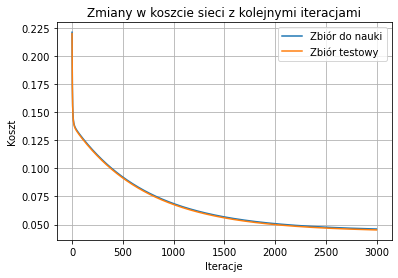

In [24]:
plt.plot(NN.J, label='Zbiór do nauki')
plt.plot(NN.testJ, label='Zbiór testowy')
plt.grid(1)
plt.title('Zmiany w koszcie sieci z kolejnymi iteracjami')
plt.xlabel('Iteracje')
plt.ylabel('Koszt')
plt.legend()
plt.show()

In [25]:
NN.predict(test_X)

array([[0.10305879],
       [0.11627419],
       [0.11362494],
       ...,
       [0.10242197],
       [0.10543375],
       [0.11009423]])

In [26]:
test_y

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]])

In [27]:
test = np.array([0,1,1,0.4,0,1,0,0,0,0,1,1,1,0.7]) ## Predykcja dla testowej osoby o wybranych cechach
NN.predict(test)

array([0.11210259])

In [28]:
## Test ilości pozytywnych i negatywnych wyników w próbie
ones = 0
zeros = 0
for i in y:
    if i == 1:
        ones += 1
    else:
        zeros += 1
print("ones: ", ones," and zeros: ", zeros)

ones:  19199  and zeros:  183745
